We call it a PR quadtree (P for point and R for region), although the term PR quadtrie would probably be more
appropriate. The PR quadtree is organized in the same way as the region quadtree. The difference is that leaf nodes are either empty (i.e., white) or contain a data point (i.e., black) and its coordinate values

https://en.wikipedia.org/wiki/Quadtree \
**Дерево квадрантов** (также квадродерево, 4-дерево, англ. quadtree) — дерево, в котором у каждого внутреннего узла ровно 4 потомка. Деревья квадрантов часто используются для рекурсивного разбиения двухмерного пространства по 4 квадранта (области). Области представляют собой квадраты, прямоугольники или имеют произвольную форму. Англоязычный термин quadtree был придуман Рафаэлем Финкелем и Джоном Бентли (англ.)русск. в 1974 году. Аналогичное разбиение пространства известно как Q-дерево. Общие черты разных видов деревьев квадрантов:

разбиение пространства на адаптирующиеся ячейки (англ. adaptable cells),
максимально возможный объём каждой ячейки,
соответствие направления дерева пространственному разбиению.

The location of records with two-dimeusional keys will be stored in a tree with out-degree four at each node. Each node will store one record andwill have up to four sons, each a node. The root of the tree divides the universe into four quadrants, namely `NE`, `NW`, `SW`, and `SE` (using the map analogy). Let us call these quadrants `one`, `two`, `three` and `four`, respectively. Fig. f shows the correspondence between a simple tree and the records it represents.\
The convention we use for points which lie directly on one of the quadrant lines emanating from a node is as follows: Quadrants one and three are closed,

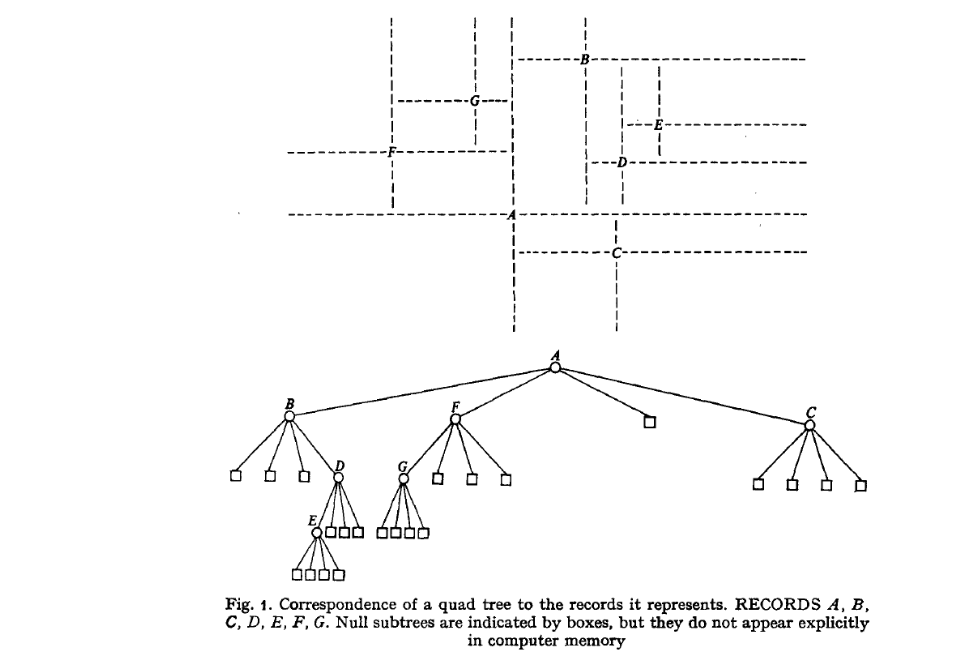

### Types
- `Region quadtree`: The region quadtree represents a partition of space in two dimensions by decomposing the region into four equal quadrants, subquadrants, and so on with each leaf node containing data corresponding to a specific subregion. Each node in the tree either has exactly four children, or has no children (a leaf node). A region quadtree with a depth of n may be used to represent an image. If a region quadtree is used to represent a set of point data (such as the latitude and longitude of a set of cities), regions are subdivided `until each leaf contains at most a single point`.
- `Points quadtrees`- The first point that is inserted serves as the root, and the second point is inserted into the relevant quadrant of the tree rooted at the first point. Clearly, the shape of the tree depends on the order in which the points were inserted.

### Реализация Point Quadtree ниже:

Сложность алгоритма:\
**Insertion** - Finkel and Bentley [614] have shown empirically that for N points, the TPL (total lenght path) of a point quadtree under random insertion is roughly proportional to $TPL = N * log_4 N$. Average cost $O(log_4N)$ of inserting. Devroye and Laforest [486], as well as Flajolet, Gonnet, Puech, and Robson [618] have shownindependently that the asymptotic expected cost of inserting the ith node in a random d-dimensional point quadtree is (2/d)lni +O(1).\
**Expected height** - Devroye [484, 485] shows that the expected height of a point quadtree is logarithmic and asymptotic to $2c/d lnN$, where c=4.31107. Of course, the extreme case is much worse (see Exercise 9) and is a function of the shape of the resulting point quadtree. This is dependent on the order in which nodes are inserted into it. The worst case arises when each successive node is the child of the currently deepest node in the tree.\
**Deletion procedure** - n*log(n), поскольку нужно сперва найти элемент, а затем reinsert childs обратно в quadtree

- 3. Suppose that you could construct the optimized point quadtree (i.e., minimal depth) for N nodes. What is the worst-case depth of an optimized point quadtree? - **$log_2N$ when all points are collinear (i.e., they lie on a straight line, случай binary tree search).**
- 4. What is the maximum TPL in an optimized point quadtree?
- 5. Analyze the running time of the algorithm for constructing an optimized point quadtree.
- 8. The TPL can also be reduced by applying balancing operators analogous to those used to balance binary search trees.
- 9. What is the worst-case cost of building a point quadtree of N nodes?


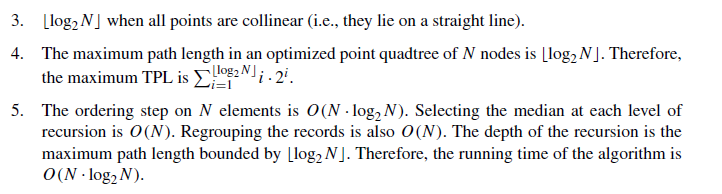


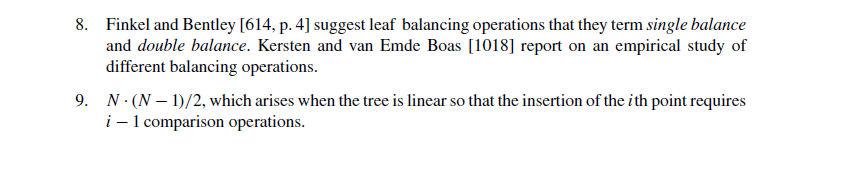

In [128]:
# реализовать point quadtree

### Реализация Range QuadTree из википедии:

<IPython.core.display.Javascript object>


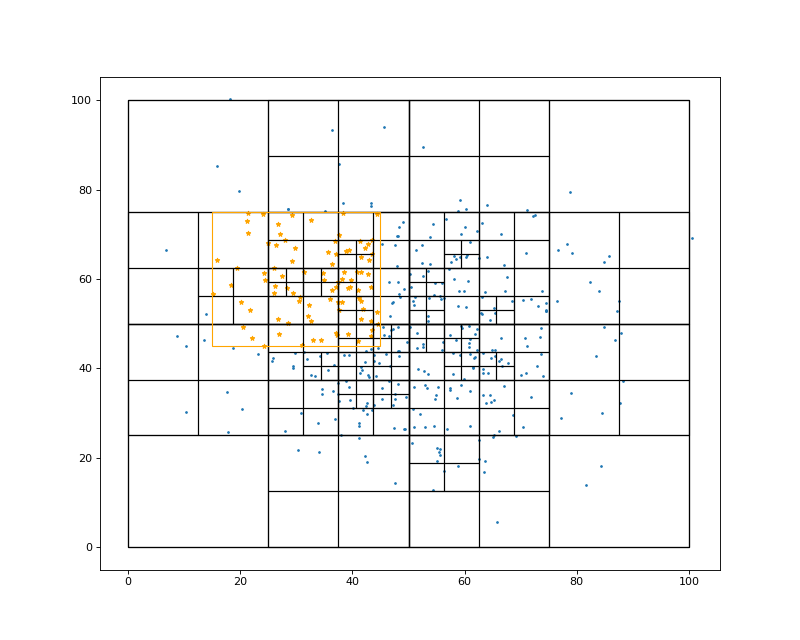

In [108]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as patches
import numpy as np


class XY:
    '''
    node
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y

class AABB:
    '''
    Axis-aligned bounding box with half dimension and center
    '''
    def __init__(self, xy, dim):
        '''
        :param xy: XY obj
        :param dim: float size of AABB side
        '''
        self.xy = xy
        self.dim = dim
    
    def contains_point(self, point):
        '''
        :param point: XY obj
        :return: True or False
        '''
        hb = self.xy.x < point.x < (self.xy.x + self.dim) # horizontals borderd
        vb = self.xy.y < point.y < (self.xy.y + self.dim) # vertical borders
        
        return hb and vb
    
    def intersects_AABB(self, aabb):
        x1, y1, dim1 = self.xy.x, self.xy.y, self.dim
        x2, y2, dim2 = aabb.xy.x, aabb.xy.y, aabb.dim
        
        if (x1 + dim1 < x2) or (x2 + dim2 < x1) or (y1 + dim1 < y2) or (y2 + dim2 < y1):
            return False # no intersections
        return True # intersection exist
        

class QuadTree:
    """
    QuadTree without distribution points when node is subdivided because overflow of points
    
    """
    def __init__(self, _aabb):
        self.boundary = _aabb
        self.capacity = 4 # quadtree node capacity
        # Axis-aligned bounding box stored as a center with half-dimensions
        # to represent the boundaries of this quad tree
        self.points = []
        self.northwest = None
        self.northeast = None
        self.southwest = None
        self.southeast = None

    
    def insert(self, xy):
        # Ignore objects that do not belong in this quad tree
        if (not self.boundary.contains_point(xy)):
            return False # point cannot be added to the quadtree
        
        if(len(self.points) < self.capacity):
            self.points.append(xy)
            return True
        elif(self.northwest == None): # just check if any link to childs exist
            self.subdivide() # if not, then subdivide that

        if self.northwest.insert(xy): return True
        if self.northeast.insert(xy): return True
        if self.southwest.insert(xy): return True
        if self.southeast.insert(xy): return True
    
    def subdivide(self):
        '''
        create four children that fully divide this quad into four quads of equal area
        '''
        nw = AABB(self.boundary.xy, self.boundary.dim / 2)
        self.northwest = QuadTree(nw)
        ne = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y), self.boundary.dim/2)
        self.northeast = QuadTree(ne)
        sw = AABB(XY(self.boundary.xy.x, self.boundary.xy.y + self.boundary.dim / 2), self.boundary.dim/2)
        self.southwest = QuadTree(sw)
        se = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y + self.boundary.dim/2), self.boundary.dim/2)
        self.southeast = QuadTree(se)

    
    def queryrange(self, aabb):
        '''
        :param aabb: AABB obj, range within we want to find points
        '''
        points_in = []
        if (not self.boundary.intersects_AABB(aabb)): # intersects or not
            return points_in 
        for p in self.points:
            if aabb.contains_point(p):
                points_in.append(p)
        
        if self.northwest == None:
            return points_in
        points_in.extend(self.northwest.queryrange(aabb))
        points_in.extend(self.northeast.queryrange(aabb))
        points_in.extend(self.southwest.queryrange(aabb))
        points_in.extend(self.southeast.queryrange(aabb))
                         
        return points_in
    
    def traversal(self):
        if self.northwest == None:
            return []
        rects = []
        for tree in [self.northwest, self.northeast, self.southwest, self.southeast]:
            (xy, dim) = [tree.boundary.xy.x, tree.boundary.xy.y], tree.boundary.dim
            rects.append((xy, dim))
            rects.extend(tree.traversal())
        return rects

# init boundary of main node of Quadtree
init_aabb = AABB(XY(0,0), 100)

qtree = QuadTree(init_aabb)
random_points = np.random.normal(50, 16.6, [400,2])
for point in random_points:
    qtree.insert(XY(point[0], point[1]))

# код, отвечающий за вывод

fig, ax = plt.subplots(1, figsize=(10, 8) )
x,y,dim = init_aabb.xy.x, init_aabb.xy.y, init_aabb.dim
rect = patches.Rectangle(xy = [x,y], width=dim, height=dim, fill=None)
ax.add_patch(rect)
for rect in qtree.traversal():
    rect = patches.Rectangle(xy = rect[0], width=rect[1], height=rect[1], fill=None)
    ax.add_patch(rect)
ax.scatter(random_points[:,0], random_points[:,1], s=2)

# query range
x,y,dim = 15,45,30
aabb_query = AABB(XY(x,y), dim)
rect = patches.Rectangle(xy = [x,y], width=dim, height=dim, fill=None, color="orange")
ax.add_patch(rect)
points_in = qtree.queryrange(aabb_query)
for x in points_in:
    ax.scatter(x.x, x.y, s=15, c="orange", marker="*")

<IPython.core.display.Javascript object>


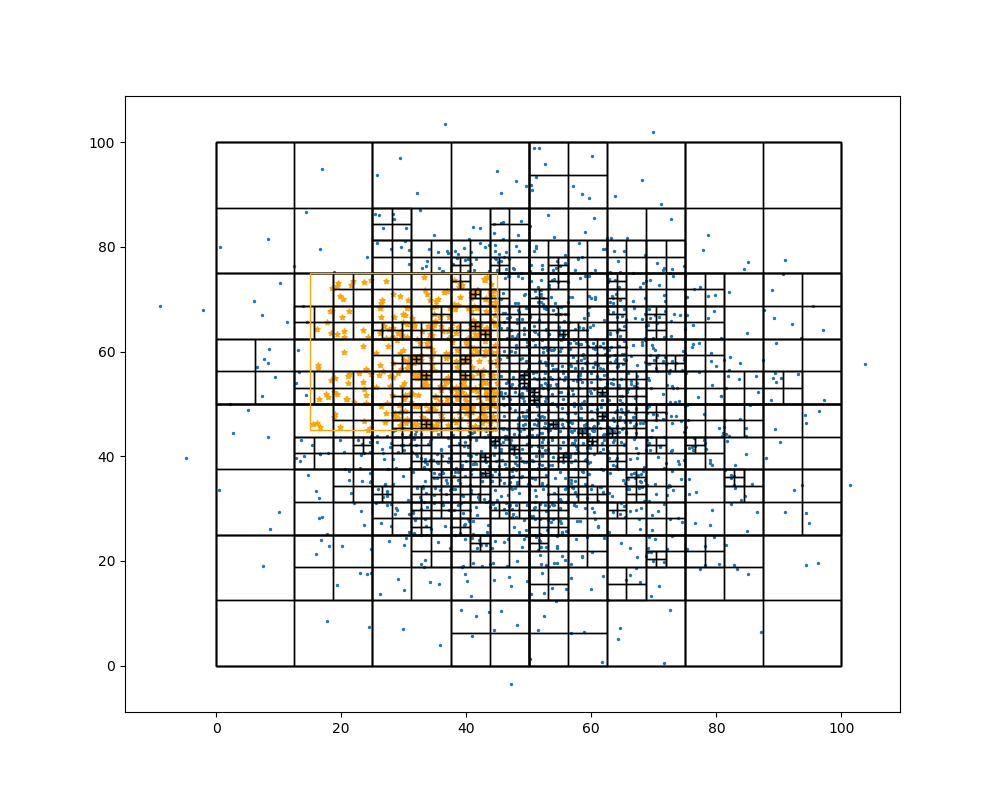

In [20]:
import matplotlib.pyplot as plt
%matplotlib notebook
import matplotlib.patches as patches
import numpy as np


class XY:
    '''
    node
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y

class AABB:
    '''
    Axis-aligned bounding box with half dimension and center
    '''
    def __init__(self, xy, dim):
        '''
        :param xy: XY obj
        :param dim: float size of AABB side
        '''
        self.xy = xy
        self.dim = dim
    
    def contains_point(self, point):
        '''
        :param point: XY obj
        :return: True or False
        '''
        hb = self.xy.x < point.x < (self.xy.x + self.dim) # horizontals borderd
        vb = self.xy.y < point.y < (self.xy.y + self.dim) # vertical borders
        
        return hb and vb
    
    def intersects_AABB(self, aabb):
        x1, y1, dim1 = self.xy.x, self.xy.y, self.dim
        x2, y2, dim2 = aabb.xy.x, aabb.xy.y, aabb.dim
        
        if (x1 + dim1 < x2) or (x2 + dim2 < x1) or (y1 + dim1 < y2) or (y2 + dim2 < y1):
            return False # no intersections
        return True # intersection exist
        

class QuadTree:
    def __init__(self, _aabb):
        self.boundary = _aabb
        self.capacity = 4 # bucket quadtree node capacity
        # Axis-aligned bounding box stored as a center with half-dimensions
        # to represent the boundaries of this quad tree
        self.points = []
        # if below links are emplty, this means that the node are leaf 
        self.northwest = None
        self.northeast = None
        self.southwest = None
        self.southeast = None

    
    def insert(self, xy):
        # Ignore objects that do not belong in this quad tree
        if (not self.boundary.contains_point(xy)):
            return False # point cannot be added to the quadtree
        points = [xy]
        if (self.northwest == None):
            if(len(self.points) < self.capacity):
                self.points.append(xy)
                return True
            else:
                self.subdivide() # if not, then subdivide that
                points.extend(self.points)
                self.points = []
        for point in points:
            if not self.northwest.insert(point):
                if not self.northeast.insert(point):
                    if not self.southwest.insert(point):
                        if not self.southeast.insert(point):
                            return False
        return True


    
    def subdivide(self):
        '''
        create four children that fully divide this quad into four quads of equal area
        '''
        nw = AABB(self.boundary.xy, self.boundary.dim / 2)
        self.northwest = QuadTree(nw)
        ne = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y), self.boundary.dim/2)
        self.northeast = QuadTree(ne)
        sw = AABB(XY(self.boundary.xy.x, self.boundary.xy.y + self.boundary.dim / 2), self.boundary.dim/2)
        self.southwest = QuadTree(sw)
        se = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y + self.boundary.dim/2), self.boundary.dim/2)
        self.southeast = QuadTree(se)

    
    def queryrange(self, aabb):
        '''
        :param aabb: AABB obj, range within we want to find points
        '''
        points_in = []
        if (not self.boundary.intersects_AABB(aabb)): # intersects or not
            return points_in 
        for p in self.points:
            if aabb.contains_point(p):
                points_in.append(p)
        
        if self.northwest == None:
            return points_in
        points_in.extend(self.northwest.queryrange(aabb))
        points_in.extend(self.northeast.queryrange(aabb))
        points_in.extend(self.southwest.queryrange(aabb))
        points_in.extend(self.southeast.queryrange(aabb))
                         
        return points_in
    
    def traversal(self):
        if self.northwest == None:
            return []
        rects = []
        for tree in [self.northwest, self.northeast, self.southwest, self.southeast]:
            (xy, dim) = [tree.boundary.xy.x, tree.boundary.xy.y], tree.boundary.dim
            rects.append((xy, dim))
            rects.extend(tree.traversal())
        return rects

# init boundary of main node of Quadtree
init_aabb = AABB(XY(0,0), 100)

qtree = QuadTree(init_aabb)
random_points = np.random.normal(50, 16.6, [2000,2])
for point in random_points:
    qtree.insert(XY(point[0], point[1]))

# код, отвечающий за вывод

fig, ax = plt.subplots(1, figsize=(10, 8) )
x,y,dim = init_aabb.xy.x, init_aabb.xy.y, init_aabb.dim
rect = patches.Rectangle(xy = [x,y], width=dim, height=dim, fill=None)
ax.add_patch(rect)
for rect in qtree.traversal():
    rect = patches.Rectangle(xy = rect[0], width=rect[1], height=rect[1], fill=None)
    ax.add_patch(rect)
ax.scatter(random_points[:,0], random_points[:,1], s=2)

# query range
x,y,dim = 15,45,30
aabb_query = AABB(XY(x,y), dim)
rect = patches.Rectangle(xy = [x,y], width=dim, height=dim, fill=None, color="orange")
ax.add_patch(rect)
points_in = qtree.queryrange(aabb_query)
for x in points_in:
    ax.scatter(x.x, x.y, s=15, c="orange", marker="*")

### Время построения дерева и время range search для двух видов Bucket PR Quadtree (без разделения точек) и сравнение с O(n) range поиском

In [86]:
import time
from tqdm import tqdm_notebook
class QuadTree:
    """
    QuadTree without distribution points when node is subdivided because overflow of points
    
    """
    def __init__(self, _aabb):
        self.boundary = _aabb
        self.capacity = 4 # quadtree node capacity
        # Axis-aligned bounding box stored as a center with half-dimensions
        # to represent the boundaries of this quad tree
        self.points = []
        self.northwest = None
        self.northeast = None
        self.southwest = None
        self.southeast = None

    
    def insert(self, xy):
        # Ignore objects that do not belong in this quad tree
        if (not self.boundary.contains_point(xy)):
            return False # point cannot be added to the quadtree
        
        if(len(self.points) < self.capacity):
            self.points.append(xy)
            return True
        elif(self.northwest == None): # just check if any link to childs exist
            self.subdivide() # if not, then subdivide that

        if self.northwest.insert(xy): return True
        if self.northeast.insert(xy): return True
        if self.southwest.insert(xy): return True
        if self.southeast.insert(xy): return True
    
    def subdivide(self):
        '''
        create four children that fully divide this quad into four quads of equal area
        '''
        nw = AABB(self.boundary.xy, self.boundary.dim / 2)
        self.northwest = QuadTree(nw)
        ne = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y), self.boundary.dim/2)
        self.northeast = QuadTree(ne)
        sw = AABB(XY(self.boundary.xy.x, self.boundary.xy.y + self.boundary.dim / 2), self.boundary.dim/2)
        self.southwest = QuadTree(sw)
        se = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y + self.boundary.dim/2), self.boundary.dim/2)
        self.southeast = QuadTree(se)

    
    def queryrange(self, aabb):
        '''
        :param aabb: AABB obj, range within we want to find points
        '''
        points_in = []
        if (not self.boundary.intersects_AABB(aabb)): # intersects or not
            return points_in 
        for p in self.points:
            if aabb.contains_point(p):
                points_in.append(p)
        
        if self.northwest == None:
            return points_in
        points_in.extend(self.northwest.queryrange(aabb))
        points_in.extend(self.northeast.queryrange(aabb))
        points_in.extend(self.southwest.queryrange(aabb))
        points_in.extend(self.southeast.queryrange(aabb))
                         
        return points_in
    
    def traversal(self):
        if self.northwest == None:
            return []
        rects = []
        for tree in [self.northwest, self.northeast, self.southwest, self.southeast]:
            (xy, dim) = [tree.boundary.xy.x, tree.boundary.xy.y], tree.boundary.dim
            rects.append((xy, dim))
            rects.extend(tree.traversal())
        return rects

class QuadTreeWS:
    """With splitting
        Спойлер - разницы вообще нету, разбивать или не разбивать - все равно
    """
    def __init__(self, _aabb):
        self.boundary = _aabb
        self.capacity = 4 # bucket quadtree node capacity
        # Axis-aligned bounding box stored as a center with half-dimensions
        # to represent the boundaries of this quad tree
        self.points = []
        # if below links are emplty, this means that the node are leaf 
        self.northwest = None
        self.northeast = None
        self.southwest = None
        self.southeast = None

    
    def insert(self, xy):
        # Ignore objects that do not belong in this quad tree
        if (not self.boundary.contains_point(xy)):
            return False # point cannot be added to the quadtree
        points = [xy]
        if (self.northwest == None):
            if(len(self.points) < self.capacity):
                self.points.append(xy)
                return True
            else:
                self.subdivide() # if not, then subdivide that
                points.extend(self.points)
                self.points = []
        for point in points:
            if not self.northwest.insert(point):
                if not self.northeast.insert(point):
                    if not self.southwest.insert(point):
                        if not self.southeast.insert(point):
                            return False
        return True


    
    def subdivide(self):
        '''
        create four children that fully divide this quad into four quads of equal area
        '''
        nw = AABB(self.boundary.xy, self.boundary.dim / 2)
        self.northwest = QuadTree(nw)
        ne = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y), self.boundary.dim/2)
        self.northeast = QuadTree(ne)
        sw = AABB(XY(self.boundary.xy.x, self.boundary.xy.y + self.boundary.dim / 2), self.boundary.dim/2)
        self.southwest = QuadTree(sw)
        se = AABB(XY(self.boundary.xy.x + self.boundary.dim / 2, self.boundary.xy.y + self.boundary.dim/2), self.boundary.dim/2)
        self.southeast = QuadTree(se)

    
    def queryrange(self, aabb):
        '''
        :param aabb: AABB obj, range within we want to find points
        '''
        points_in = []
        if (not self.boundary.intersects_AABB(aabb)): # intersects or not
            return points_in 
        for p in self.points:
            if aabb.contains_point(p):
                points_in.append(p)
        
        if self.northwest == None:
            return points_in
        points_in.extend(self.northwest.queryrange(aabb))
        points_in.extend(self.northeast.queryrange(aabb))
        points_in.extend(self.southwest.queryrange(aabb))
        points_in.extend(self.southeast.queryrange(aabb))
                         
        return points_in
    
    def traversal(self):
        if self.northwest == None:
            return []
        rects = []
        for tree in [self.northwest, self.northeast, self.southwest, self.southeast]:
            (xy, dim) = [tree.boundary.xy.x, tree.boundary.xy.y], tree.boundary.dim
            rects.append((xy, dim))
            rects.extend(tree.traversal())
        return rects
    
    
build_duration = []
range_search_duration = []
search_n = []
build_duration_with_split = []
range_search_with_split_duration = []
nb_of_points = np.arange(100, 20000, step=500)
iterations = 3

for nb in tqdm_notebook(nb_of_points):
    random_points = np.random.normal(50, 16.6, [nb,2])
    
    
    for i in range(iterations):
        # Quad tree without splitting
        start_build = time.time()
        init_aabb = AABB(XY(0,0), 100) # init boundary of main node of Quadtree
        qtree = QuadTree(init_aabb)
        for point in random_points:
            qtree.insert(XY(point[0], point[1]))
        end_build = time.time()
        build_duration.append((end_build - start_build) * 1000)
                
        
        start_search = time.time()
        # query range
        x,y,dim = 15,45,30
        aabb_query = AABB(XY(x,y), dim)
        points_in = qtree.queryrange(aabb_query)
        end_search = time.time()
        range_search_duration.append((end_search - start_search) * 1000)
        
        # Quad tree with splitting
        start_build = time.time()
        init_aabb = AABB(XY(0,0), 100) # init boundary of main node of Quadtree
        qtreeWS = QuadTreeWS(init_aabb)
        for point in random_points:
            qtreeWS.insert(XY(point[0], point[1]))
        end_build = time.time()
        build_duration_with_split.append((end_build - start_build) * 1000)
        
                
        start_search = time.time()
        # query range
        x,y,dim = 15,45,30
        aabb_query = AABB(XY(x,y), dim)
        points_in = qtreeWS.queryrange(aabb_query)
        end_search = time.time()
        range_search_with_split_duration.append((end_search - start_search) * 1000)
        
        #search O(n)
        start_search = time.time()
        points_in = []
        for p in random_points:
            if aabb_query.contains_point(XY(p[0], p[1])):
                points_in.append(p)
        end_search = time.time()
        search_n.append((end_search - start_search) * 1000)


d:\jupyter\venv\lib\site-packages\ipykernel_launcher.py:171: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


<IPython.core.display.Javascript object>


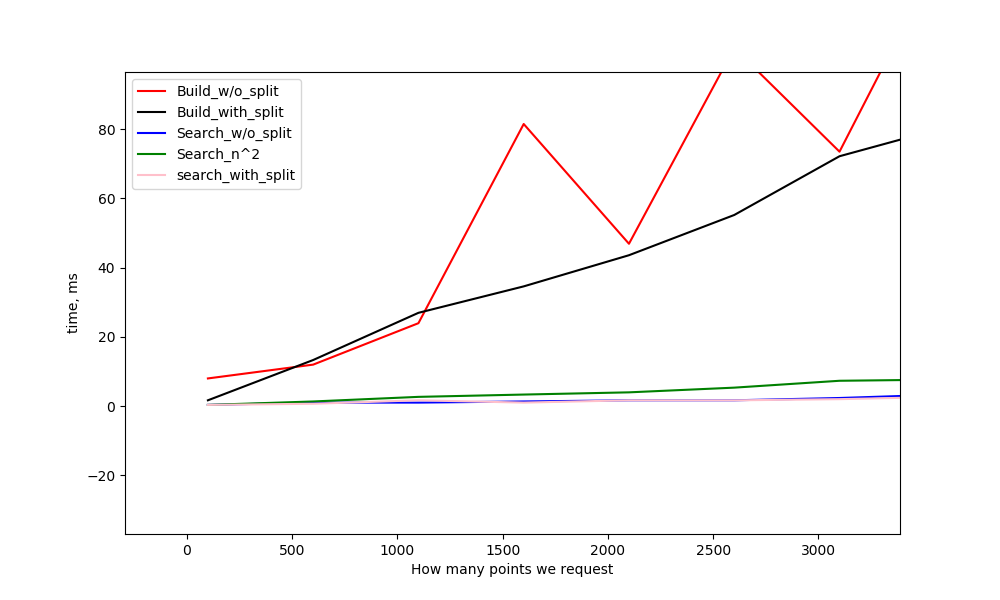

In [98]:
b_times = np.array(build_duration)
b_times_list = []

for i in b_times.reshape(-1,3,1):
    b_times_list.append(i.mean())
    
s_times = np.array(range_search_duration)
s_times_list = []
for i in s_times.reshape(-1,3,1):
    s_times_list.append(i.mean())

search_n = np.array(search_n)  
search_n_list = []
for i in search_n.reshape(-1,3,1):
    search_n_list.append(i.mean())

build_duration_with_split = np.array(build_duration_with_split)
build_duration_with_split_list = []
for i in build_duration_with_split.reshape(-1,3,1):
    build_duration_with_split_list.append(i.mean())
    
range_search_with_split_duration = np.array(range_search_with_split_duration)
range_search_with_split_duration_list = []
for i in range_search_with_split_duration.reshape(-1,3,1):
    range_search_with_split_duration_list.append(i.mean())

fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.set_xlabel('How many points we request')
ax.set_ylabel('time, ms')
# you can also build times array on the same graph
plt.plot(nb_of_points, b_times_list, label="Build_w/o_split", c="r")
plt.plot(nb_of_points, build_duration_with_split_list, label="Build_with_split", c="black")
plt.plot(nb_of_points, s_times_list, label="Search_w/o_split", c="b")
plt.plot(nb_of_points, search_n_list, label="Search_n^2", c="g")
plt.plot(nb_of_points, range_search_with_split_duration_list, label="search_with_split", c="pink")
plt.legend()
plt.show()

In [91]:
range_search_with_split_duration_list

[0.3325939178466797,
 0.6659825642903646,
 1.6649564107259114,
 0.9963512420654297,
 1.6616185506184895,
 1.6520023345947266,
 1.993258794148763,
 2.6487509409586587,
 3.323078155517578,
 3.9884249369303384,
 4.967610041300456,
 4.0073394775390625,
 4.327932993570964,
 5.652189254760742,
 5.661249160766602,
 4.987955093383789,
 5.994240442911784,
 7.295290629069011,
 7.640600204467773,
 5.649248758951823,
 7.6249440511067705,
 6.298621495564778,
 6.647268931070964,
 7.312218348185222,
 7.632335027058919,
 8.672157923380533,
 8.33288828531901,
 10.307629903157553,
 10.638872782389322,
 14.295657475789389,
 9.973605473836264,
 9.306192398071289,
 12.644688288370768,
 15.281359354654947,
 11.967976888020834,
 19.640684127807617,
 12.634595235188803,
 11.967976888020834,
 18.284320831298828,
 13.321240743001303]

#### Сложность алгоритма для кол-ва точек, расположенных на радиусе 1 метр с периодом 0.2 мм

In [142]:

print("O(n*n)", (2 * np.pi * 1/0.0002) * (2 * np.pi * 1/0.0002))

O(n*n) 986960440.1089356


In [144]:
print("O(n*log(n))", (2 * np.pi * 1/0.0002) * np.log2(2 * np.pi * 1/0.0002))

O(n*log(n)) 469329.07702388905
